# Supervised Learning with Neural Networks

In this tutorial we show how to optimize a neural networks to approximate the state given. In this example, we consider the ground state of the J1-J2 model in one-dimension obtained from ED using NetKet. 

The Hamiltonian of the model is given by:
$$ H = \sum_{i=1}^{L} J_{1}\hat{S}_{i} \cdot \hat{S}_{i+1} + J_{2} \hat{S}_{i} \cdot \hat{S}_{i+2} $$
where the sum is over sites of the 1-D chain.


## Outline:
    1. Obtain data from ED
    2. Choosing the machine (variational ansatz) and the optimizer
    3. Defining the Supervised Learning object
    4. Running the Supervised Learning
    5. Data Visualisation
    


In [1]:
# Import netket library
import netket as nk
from mpi4py import MPI

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

## 1) Obtain data from ED

For a supervised learning problem, we would need to provide the data including input $X$ and output label $Y$. The neural network is asked to learn the mapping $Y=f(X)$. In our case, the input is the spin basis and the output is the coefficient of the corresponding spin basis. 

First, we write a simple function to obtain data, i.e. ground state, from exact diagonalization. For detailed explanation see the tutorial for J1-J2 model for example.

In [2]:
def load_ed_data(L, J2=0.4):
    # Sigma^z*Sigma^z interactions
    sigmaz = np.array([[1, 0], [0, -1]])
    mszsz = (np.kron(sigmaz, sigmaz))

    # Exchange interactions
    exchange = np.asarray(
        [[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

    # Couplings J1 and J2
    J = [1., J2]

    mats = []
    sites = []

    for i in range(L):
        for d in [0, 1]:
            # \sum_i J*sigma^z(i)*sigma^z(i+d)
            mats.append((J[d] * mszsz).tolist())
            sites.append([i, (i + d + 1) % L])

            # \sum_i J*(sigma^x(i)*sigma^x(i+d) + sigma^y(i)*sigma^y(i+d))
            mats.append(((-1.)**(d + 1) * J[d] * exchange).tolist())
            sites.append([i, (i + d + 1) % L])

    # 1D Lattice
    g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

    # Spin based Hilbert Space
    hi = nk.hilbert.Spin(s=0.5, graph=g)

    # Custom Hamiltonian operator
    ha = nk.operator.LocalOperator(hi)
    for mat, site in zip(mats, sites):
        ha += nk.operator.LocalOperator(hi, mat, site)

    # Perform Lanczos Exact Diagonalization to get lowest three eigenvalues
    res = nk.exact.lanczos_ed(ha, first_n=3, compute_eigenvectors=True)

    # Eigenvector
    ttargets = []

    tsamples = []
    hind = nk.hilbert.HilbertIndex(hi)

    for i in range(hind.n_states):
        visible = hind.number_to_state(i)
        # only pick zero-magnetization states
        mag = np.sum(visible)
        if(np.abs(mag) < 1.0e-4):
            tsamples.append(visible.tolist())
            ttargets.append([np.log(res.eigenvectors[0][i])])

    return hi, tsamples, ttargets


After we obtain the result as ``res``, we return the hilbert space ``hi``, the spin basis ``tsamples``, and the coefficients ``ttargets``.

Notice that we restrict ourselves to $\sum S_z = 0$ symmetry sector to simplify the learning.

We now consider a small system $L=10$ and with $J_2 = 0.4$, and obtain the data by calling the function ```load_ed_data```.

In [3]:
L = 10
J2 = 0.4

# Load the Hilbert space info and data
hi, training_samples, training_targets = load_ed_data(L, J2)


## 2) Choosing the Machine and the Optimizer

For this tutorial, we consider the Restricted Bolzmann Machine ``nk.machine.RbmSpin`` and the AdaDelta optimizer ``nk.optimizer.AdaDelta``.

In [4]:
# Machine
ma = nk.machine.RbmSpin(hilbert=hi, alpha=1)
ma.init_random_parameters(seed=1234, sigma=0.01)
# Optimizer
op = nk.optimizer.AdaDelta()

## 3) Defining the Supervised Learning object

We have now have almost everything (machine, optimizer, data) for setting up a supervised learning object. We also need to provide the batch size, ``batch_size``, for stochatic gradient descent. For detail, see https://en.wikipedia.org/wiki/Stochastic_gradient_descent




In [5]:
# Supervised learning object
spvsd = nk.supervised.Supervised(
    machine=ma,
    optimizer=op,
    batch_size=400,
    samples=training_samples,
    targets=training_targets)


## 4) Running the Supervised Learning

The very last piece we need for supervised learning is the loss function.

### Loss function
There are different loss functions one could define for the optimization problem, for example:
\begin{align*}
        \mathcal{L}_\text{MSE log} &= \frac{1}{N} \sum_{i}^N |\log\Psi(X_i) - \log\Phi(X_i) |^2\\
        \mathcal{L}_\text{Overlap} &=-\log\Big[ \frac{\langle{\Psi|\Phi}\rangle\langle{\Phi|\Psi}\rangle}{\langle{\Psi|\Psi}\rangle\langle{\Phi|\Phi}\rangle} \Big] \\
        &=- \log\Big( \sum_{i}^N \Psi^*(X_i)\Phi(X_i) \Big) - \log\Big( \sum_{i}^N \Phi^*(X_i)\Psi(X_i) \Big) \\
        &\qquad +
        \log\Big( \sum_{i}^N \Psi^*(X_i)\Psi(X_i) \Big) +
        \log\Big( \sum_{i}^N \Phi^*(X_i)\Phi(X_i) \Big)
\end{align*}

Here, we consider the latter one, which is the negative log of the overlap, as the loss function.




### Gradient estimate
Taking the derivative from overlap errror function above, we have
\begin{equation*}
    \partial_k \mathcal{L}_\text{Overlap} = -\frac{\sum_i O_k^*\Psi^*(X_i)\Phi(X_i) }{\sum_i\Psi^*(X_i)\Phi(X_i)} + \frac{\sum_i O_k^*\Psi^*(X_i)\Psi(X_i)}{\sum_i \Psi^*(X_i)\Psi(X_i)}
\end{equation*}

Note that $N$ is the size of the Hilbert space. In general, this could not be computed exactly.


We could estimate this gradient by sampling different distributions,
\begin{equation}
    \hat{\partial_k \mathcal{L}}_\text{Overlap uni} = \frac{\Big\langle O_k^*\Psi^*(X_i)\Psi(X_i)\Big \rangle_{i\sim\text{uni}[1,N]} }{\Big \langle \Psi^*(X_i)\Psi(X_i) \Big \rangle_{i\sim\text{uni}[1,N]}} - \frac{\Big \langle O_k^*\Psi^*(X_i)\Phi(X_i)\Big \rangle_{i\sim\text{uni}[1,N]} }{\Big \langle \Psi^*(X_i)\Phi(X_i) \Big \rangle_{i\sim\text{uni}[1,N]}} 
\end{equation}
\begin{equation}
    \hat{\partial_k \mathcal{L}}_\text{Overlap phi} = \frac{\Big \langle O_k^*(X_i)\frac{\lVert \Psi(X_i)\rVert^2}{\lVert \Phi(X_i)\rVert^2} \Big \rangle_{X_i\sim \lVert \Phi(X_i)\rVert^2 }}   {\Big \langle \frac{\lVert \Psi(X_i)\rVert^2}{\lVert \Phi(X_i)\rVert^2} \Big \rangle_{X_i\sim \lVert \Phi(X_i)\rVert^2 }} - \frac{\Big \langle O_k^*(X_i)\frac{ \Psi^*(X_i)}{ \Phi^*(X_i)} \Big \rangle_{X_i\sim \lVert \Phi(X_i)\rVert^2 }}{\Big \langle \frac{ \Psi^*(X_i)}{ \Phi^*(X_i)} \Big \rangle_{X_i\sim \lVert \Phi(X_i)\rVert^2 }}
\end{equation} 



So for the overlap loss function, we have two gradient estimate, one is $\hat{\partial_k \mathcal{L}}_\text{Overlap uni}$, ```Overlap_uni```, and $\hat{\partial_k \mathcal{L}}_\text{Overlap phi}$, ```Overlap_phi```.

We save the loss function every iteration, and save the optimized parameters only every ``save_params_every`` iterations.

In [6]:
# Number of iteration
n_iter = 4000

# Run with "Overlap_phi" loss. Also available currently is "MSE, Overlap_uni"
spvsd.run(n_iter=n_iter, loss_function="Overlap_phi",
          output_prefix='output', save_params_every=50)


## 5) Data Visualisation

We have optimized our machine to approximate the ground state of the J1-J2 model. The results for the loss function are stored in the ".log" file and the optimized parameters in the ".wf" file. The files are all in json format.



In [7]:
# Load the data from the .log file
import json

data=json.load(open("output.log"))

# Extract the relevant information
iters=[]
log_overlap=[]
mse=[]
mse_log=[]

data=json.load(open('output.log'))
for iteration in data["Output"]:
    iters.append(iteration["Iteration"])
    log_overlap.append(iteration["log_overlap"])
    mse.append(iteration["mse"])
    mse_log.append(iteration["mse_log"])

overlap = np.exp(-np.array(log_overlap))


Now, we plot the overlap, i.e. fidelity, with respect to the number of iteration.

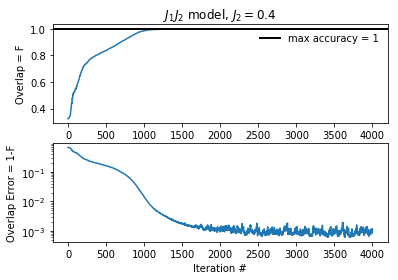

In [8]:

J2 = 0.4

plt.subplot(2, 1, 1)
plt.title(r'$J_1 J_2$ model, $J_2=' + str(J2) + '$')
plt.ylabel('Overlap = F')
plt.xlabel('Iteration #')

plt.plot(iters, overlap)
plt.axhline(y=1, xmin=0, xmax=iters[-1], linewidth=2, color='k',label='max accuracy = 1')

plt.legend(frameon=False)

plt.subplot(2, 1, 2)
plt.ylabel('Overlap Error = 1-F')
plt.xlabel('Iteration #')
plt.semilogy(iters, 1.-overlap)
plt.show()


The result suggests that indeed we could have a good approximate to the state given by supervised learning. 